In this notebook I want to do KBest Feature Selection using a variable number of selected features (sorted by best ANOVA F-score) and plot the results

In [1]:
import ml_utils as mu
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from matplotlib import pyplot as plt

In [2]:
# get training and validation data
data = mu.get_training_data()
valid_data = mu.get_validation_data(data.columns)

[2018-06-15 16:10:16.417090] Starting Control vs. All Park
[2018-06-15 16:12:30.623517] Done with Control vs. All Park (Took 2.237 minutes minutes)

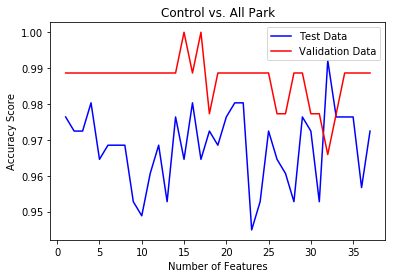

[2018-06-15 16:12:30.752532] Starting Idiopathic Park vs. Atypical Park
[2018-06-15 16:14:42.049833] Done with Idiopathic Park vs. Atypical Park (Took 2.188 minutes minutes)

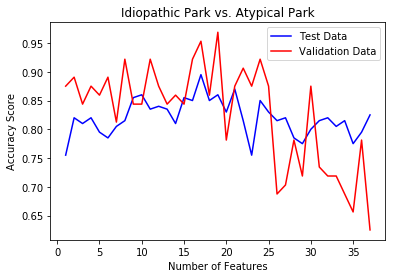

[2018-06-15 16:14:42.158797] Starting MSA vs. PSP
[2018-06-15 16:15:58.695364] Done with MSA vs. PSP (Took 1.276 minutes minutes)

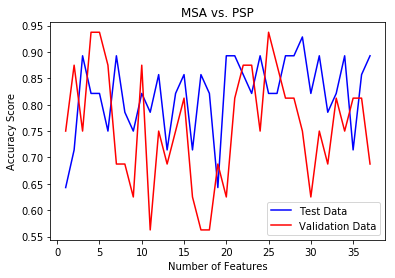

[2018-06-15 16:15:58.811387] Starting Control v. Idiopathic Park v. MSA v. PSP
[2018-06-15 16:21:12.413559] Done with Control v. Idiopathic Park v. MSA v. PSP (Took 5.227 minutes minutes)

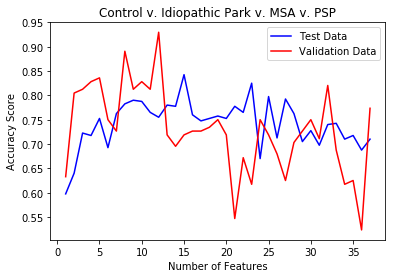

In [3]:
import sys, os
from sklearn.preprocessing import StandardScaler
import datetime
import time

# group classes and leave out unwanted data
group_descs = ["Control vs. All Park", "Idiopathic Park vs. Atypical Park", "MSA vs. PSP", "Control v. Idiopathic Park v. MSA v. PSP"]
class_groups = [{0:0, 1:1, 2:1, 3:1}, {1:1, 2:2, 3:2}, {2:2, 3:3}, {0:0, 1:1, 2:2, 3:3}] 

group_results = []
for i in range(len(class_groups)):
    start = time.time()
    print("[%s] Starting %s" %(datetime.datetime.now(), group_descs[i]))
    data_grouped = mu.group_classes(data, class_groups[i])
    valid_data_grouped = mu.group_classes(valid_data, class_groups[i])

    # split the x and y data
    X, y = mu.split_x_and_y(data_grouped)
    valid_X, valid_y = mu.split_x_and_y(valid_data_grouped)

    # split the data into test and train sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)
    
    # standardize the data to the training set    
    std_scale = StandardScaler().fit(X_train)
    X_train = std_scale.transform(X_train)
    X_test = std_scale.transform(X_test)
    valid_X = std_scale.transform(valid_X)

    # Run through all possible number of features and save the classifier, test data score and validation data scores
    clfs = []
    test_data_scores = []
    valid_data_scores = []

    ks = range(1, X.shape[1]+1)
    for k in ks:
        sys.stdout.write("\rStarting K-Best with %d features (of %d)" %(k, X.shape[1]))
        sys.stdout.flush()
    
        
        # Feature Selection using ANOVA F-score
        kbest = SelectKBest(score_func=f_classif, k=k).fit(X_train, y_train)

        # transform data using k best feature selector
        X_train_k = kbest.transform(X_train)
        X_test_k = kbest.transform(X_test)
        valid_X_k = kbest.transform(valid_X)

        with mu.HiddenPrints():
            # resample the training data to get equal class sizes
            X_train_k_res, y_train_res = mu.resample_to_equal_class_sizes(X_train_k, y_train)
            
            # resample the test and validation data so our perception of the accuracy is not skewed since most of the data is idiopathic parkinsons
            X_test_k_res, y_test_res = mu.resample_to_equal_class_sizes(X_test_k, y_test)
            valid_X_k_res, valid_y_res = mu.resample_to_equal_class_sizes(valid_X_k, valid_y)
            
            # grid search for the best SVC model
            clf = mu.svm_grid_search(X_train_k_res, X_test_k_res, y_train_res, y_test_res).best_estimator_

        clfs.append(clf)
        test_data_scores.append(clf.score(X_test_k_res, y_test_res))
        valid_data_scores.append(clf.score(valid_X_k_res, valid_y_res))
    
    end = time.time()
    time_elapsed = "%.3f minutes" %((end-start)/60)
    sys.stdout.write("\r[%s] Done with %s (Took %s minutes)" %(datetime.datetime.now(),group_descs[i], time_elapsed))
    sys.stdout.flush()

    plt.figure()
    plt.plot(ks, test_data_scores, color='blue', label='Test Data')
    plt.plot(ks, valid_data_scores, color='red', label='Validation Data')
    plt.legend()
    plt.xlabel('Number of Features')
    plt.ylabel('Accuracy Score')
    plt.title(group_descs[i])
    plt.show()
    
    group_results.append({'clfs': clfs, 'test_data_scores': test_data_scores, 'valid_data_scores': valid_data_scores})
    